##### Copyright 2020 The TensorFlow Authors.
##### Copyright 2020 Sen Pei (Columbia University).

Licensed under the Apache License, Version 2.0 (the "License");

In [143]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Substantial Undocumented Infection Facilitates the Rapid Dissemination of Novel Coronavirus (SARS-CoV2)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a TensorFlow Probability port of the eponymous 16 March 2020 paper by Li et al.  We faithfully reproduce the original authors' methods and results on the TensorFlow Probability platform, showcasing some of TFP's capabilities in the setting of modern epidemiology modeling.  Porting to TensorFlow gives us a ~10x speedup relative to the original Matlab code, and, since TensorFlow Probability pervasively supports vectorized batch computation, also favorably scales to hundreds of independent replications.

### Original paper

Ruiyun Li, Sen Pei, Bin Chen, Yimeng Song, Tao Zhang, Wan Yang, and Jeffrey Shaman. Substantial undocumented infection facilitates the rapid dissemination of novel coronavirus (SARS-CoV2). (2020), doi:
https://doi.org/10.1126/science.abb3221 .

*Abstract:* "Estimation of the prevalence and contagiousness of undocumented novel coronavirus (SARS-CoV2) infections is critical for understanding the overall prevalence and pandemic potential of this disease. Here we use observations of reported infection within China, in conjunction with mobility data, a networked dynamic metapopulation model and Bayesian inference, to infer critical epidemiological characteristics associated with SARS-CoV2, including the fraction of undocumented infections and their contagiousness. We estimate 86% of all infections were undocumented (95% CI: [82%–90%]) prior to 23 January 2020 travel restrictions. Per person, the transmission rate of undocumented infections was 55% of documented infections ([46%–62%]), yet, due to their greater numbers, undocumented infections were the infection source for 79% of documented cases. These findings explain the rapid geographic spread of SARS-CoV2 and indicate containment of this virus will be particularly challenging."

[Github link](https://github.com/SenPei-CU/COVID-19) to the code and data.

## Overview

The model is a [compartmental disease model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology), with compartments for "susceptible", "exposed" (infected but not yet infectious), "never-documented infectious", and "eventually-documented infectious". There are two noteworthy features: separate compartments for each of 375 Chinese cities, with an assumption about how people travel from one city to another; and delays in reporting infection, so that a case that becomes "eventually-documented infectious" on day $t$ doesn't show up in the observed case counts until a stochastic later day.

The model assumes that the never-documented cases end up undocumented by being milder, and thus infect others at a lower rate.  The main parameter of interest in the original paper is the proportion of cases that go undocumented, to estimate both the extent of existing infection, and the impact of undocumented transmission on the spread of the disease.

This colab is structured as a code walkthrough in bottom-up style.  In order, we will
- Ingest and briefly examine the data,
- Define the state space and dynamics of the model,
- Build up a suite of functions for doing inference in the model following Li et al, and
- Invoke them and examine the results.  Spoiler: They come out the same as the paper.


## Installation and Python Imports

In [144]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import io
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import samplers

tfd = tfp.distributions
tfes = tfp.experimental.sequential

## Data Import

Let's import the data from github and inspect some of it.

In [145]:
raw_incidence = pd.read_csv('data/inf.csv')
raw_mobility = pd.read_csv('data/mob.csv')
raw_population = pd.read_csv('data/pop.csv')

Below we can see the raw incidence count per day. We are most interested in the first 14 days (January 10th to January 23rd), as the travel restrictions were put in place on the 23rd.  The paper deals with this by modeling Jan 10-23 and Jan 23+ separately, with different parameters; we will just restrict our reproduction to the earlier period.

In [146]:
raw_incidence

,Achham,Arghakhanchi,Baglung,Baitadi,Bajhang,Bajura,Banke,Bara,Bardiya,Bhojpur,...,Sindhupalchok,Siraha,Solukhumbu,Sunsari,Surkhet,Syangja,Tanahu,Taplejung,Terhathum,Udayapur
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's sanity-check the `Udayapur` incidence counts.

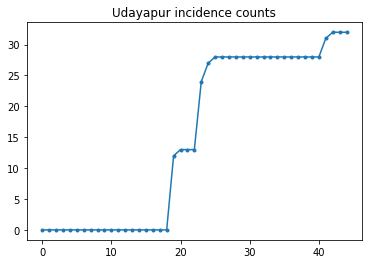

In [147]:
plt.plot(raw_incidence.Udayapur, '.-')
plt.title('Udayapur incidence counts')
plt.show()

So far, so good.  Now the initial population counts.

In [148]:
raw_population

,District,Population
0,Achham,209318
1,Arghakhanchi,139054
2,Baglung,198447
3,Baitadi,197067
4,Bajhang,165950
...,...,...
70,Syangja,213284
71,Tanahu,244365
72,Taplejung,89373
73,Terhathum,68574


Let's also check and record which entry is Wuhan.

In [149]:
raw_population['District'][74]

'Udayapur'

In [150]:
UDAYAPUR_IDX = 74

In [151]:
raw_mobility

,Origin,Destination,Mobility Index,Day
0,Achham,Arghakhanchi,12.615110,1
1,Achham,Baglung,9.195061,1
2,Achham,Baitadi,1.054381,1
3,Achham,Bajhang,0.131129,1
4,Achham,Bajura,0.165918,1
...,...,...,...,...
249745,Udayapur,Surkhet,32.095015,45
249746,Udayapur,Syangja,132.999026,45
249747,Udayapur,Tanahu,172.294193,45
249748,Udayapur,Taplejung,32.774275,45


Finally, let's preprocess all this into numpy arrays that we can consume.

In [152]:
# The given populations are only "initial" because of intercity mobility during
# the holiday season.
initial_population = raw_population['Population'].to_numpy().astype(np.float32)

Convert the mobility data into an [L, L, T]-shaped Tensor, where L is the number of locations, and T is the number of timesteps.

In [153]:
def get_mobility_matrix(origin, end):
    daily_mobility_matrices = []
    for i in range(origin, end):
      day_mobility = raw_mobility[raw_mobility['Day'] == i]

      # Make a matrix of daily mobilities.
      z = pd.crosstab(
          day_mobility.Origin, 
          day_mobility.Destination, 
          values=day_mobility['Mobility Index'], aggfunc='sum', dropna=False)

      # Include every city, even if there are no rows for some in the raw data on
      # some day.  This uses the sort order of `raw_population`.
      z = z.reindex(index=raw_population['District'], columns=raw_population['District'], 
                    fill_value=0)
      # Finally, fill any missing entries with 0. This means no mobility.
      z = z.fillna(0)
      daily_mobility_matrices.append(z.to_numpy())

    return np.stack(daily_mobility_matrices, axis=-1).astype(
        np.float32)
    
mobility_matrix_over_time = get_mobility_matrix(1,31)

Finally take the observed infections and make an [L, T] table.

In [154]:
# Remove the date parameter and take the first 14 days.
observed_daily_infectious_count = raw_incidence.to_numpy()[:30, :]
observed_daily_infectious_count = np.transpose(
    observed_daily_infectious_count).astype(np.float32)

And double-check that we got the shapes the way we wanted.  As a reminder, we're working with 375 cities and 14 days.

In [155]:
print('Mobility Matrix over time should have shape (75, 75, 30): {}'.format(
    mobility_matrix_over_time.shape))
print('Observed Infectious should have shape (75, 30): {}'.format(
    observed_daily_infectious_count.shape))
print('Initial population should have shape (75): {}'.format(
    initial_population.shape))

Mobility Matrix over time should have shape (75, 75, 30): (75, 75, 30)
Observed Infectious should have shape (75, 30): (75, 30)
Initial population should have shape (75): (75,)


## Defining State and Parameters


Let's start defining our model. The model we are reproducing is a variant of an [SEIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model). In this case we have the following time-varying states:
* $S$: Number of people susceptible to the disease in each city.
* $E$: Number of people in each city exposed to the disease but not infectious yet.  Biologically, this corresponds to contracting the disease, in that all exposed people eventually become infectious.
* $I^u$: Number of people in each city who are infectious but undocumented.  In the model, this actually means "will never be documented".
* $I^r$: Number of people in each city who are infectious and documented as such.  Li et al model reporting delays, so $I^r$ actually corresponds to something like "case is severe enough to be documented at some point in the future".

As we will see below, we will be inferring these states by running an Ensemble-adjusted Kalman Filter (EAKF) forward in time.  The state vector of the EAKF is one city-indexed vector for each of these quantities.

The model has the following inferrable global, time-invariant parameters:

* $\beta$: The transmission rate due to documented-infectious individuals.
* $\mu$: The relative transmission rate due to undocumented-infectious
  individuals. This will act through the product $\mu \beta$.
* $\theta$: The intercity mobility factor. This is a factor greater than
  1 correcting for underreporting of mobility data (and for population growth
  from 2018 to 2020).
* $Z$: The average incubation period (i.e., time in the "exposed" state).
* $\alpha$: This is the fraction of infections severe enough to be (eventually) documented.
* $D$: The average duration of infections (i.e., time in either "infectious" state).

We will be inferring point estimates for these parameters with an Iterative-Filtering loop around the EAKF for the states.

The model also depends on un-inferred constants:
* $M$: The intercity mobility matrix.  This is time-varying and presumed given.  Recall that it's scaled by the inferred parameter $\theta$ to give the actual population movements between cities.
* $N$: The total number of people in each city.  The initial populations are taken as given, and the time-variation of population is computed from the mobility numbers $\theta M$.


First, we give ourselves some data structures for holding our states and parameters.


In [156]:
SEIRComponents = collections.namedtuple(
  typename='SEIRComponents',
  field_names=[
    'susceptible',              # S
    'exposed',                  # E
    'documented_infectious',    # I^r
    'undocumented_infectious',  # I^u
    # This is the count of new cases in the "documented infectious" compartment.
    # We need this because we will introduce a reporting delay, between a person
    # entering I^r and showing up in the observable case count data.
    # This can't be computed from the cumulative `documented_infectious` count,
    # because some portion of that population will move to the 'recovered'
    # state, which we aren't tracking explicitly.
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'documented_infectious_tx_rate',             # Beta
      'undocumented_infectious_tx_relative_rate',  # Mu
      'intercity_underreporting_factor',           # Theta
      'average_latency_period',                    # Z
      'fraction_of_documented_infections',         # Alpha
      'average_infection_duration'                 # D
    ]
)

We also code Li et al's bounds for the values of the parameters.

In [157]:
PARAMETER_LOWER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=0.8,
    undocumented_infectious_tx_relative_rate=0.2,
    intercity_underreporting_factor=1.,
    average_latency_period=2.,
    fraction_of_documented_infections=0.02,
    average_infection_duration=2.
)

PARAMETER_UPPER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=1.5,
    undocumented_infectious_tx_relative_rate=1.,
    intercity_underreporting_factor=1.75,
    average_latency_period=5.,
    fraction_of_documented_infections=1.,
    average_infection_duration=5.
)

## SEIR Dynamics

Here we define the relationship between the parameters and state.

The time-dynamics equations from Li et al (supplemental material, eqns 1-5) are as follows:

$\frac{dS_i}{dt} = -\beta \frac{S_i I_i^r}{N_i} - \mu \beta \frac{S_i I_i^u}{N_i} + \theta \sum_k \frac{M_{ij} S_j}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} S_j}{N_i - I_i^r}$

$\frac{dE_i}{dt} = \beta \frac{S_i I_i^r}{N_i} + \mu \beta \frac{S_i I_i^u}{N_i} -\frac{E_i}{Z} + \theta \sum_k \frac{M_{ij} E_j}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} E_j}{N_i - I_i^r}$

$\frac{dI^r_i}{dt} = \alpha \frac{E_i}{Z} - \frac{I_i^r}{D}$

$\frac{dI^u_i}{dt} = (1 - \alpha) \frac{E_i}{Z} - \frac{I_i^u}{D} + \theta \sum_k \frac{M_{ij} I_j^u}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} I^u_j}{N_i - I_i^r}$

$N_i = N_i + \theta \sum_j M_{ij} - \theta \sum_j M_{ji}$

As a reminder, the $i$ and $j$ subscripts index cities.  These equations model the time-evolution of the disease through
- Contact with infectious individuals leading to more infection;
- Disease progression from "exposed" to one of the "infectious" states;
- Disease progression from "infectious" states to recovery, which we model by removal from the modeled population;
- Inter-city mobility, including exposed or undocumented-infectious persons; and
- Time-variation of daily city populations through inter-city mobility.

Following Li et al, we assume that people with cases severe enough to eventually be reported do not travel between cities.

Also following Li et al, we treat these dynamics as subject to term-wise Poisson noise, i.e., each term is actually the rate of a Poisson, a sample from which gives the true change.  The Poisson noise is term-wise because subtracting (as opposed to adding) Poisson samples does not yield a Poisson-distributed result.

We will evolve these dynamics forward in time with the classic fourth-order Runge-Kutta integrator, but first let's define the function that computes them (including sampling the Poisson noise).

In [158]:
def sample_state_deltas(
    state, population, mobility_matrix, params, seed, is_deterministic=False):
  """Computes one-step change in state, including Poisson sampling.
  
  Note that this is coded to support vectorized evaluation on arbitrary-shape
  batches of states.  This is useful, for example, for running multiple
  independent replicas of this model to compute credible intervals for the
  parameters.  We refer to the arbitrary batch shape with the conventional
  `B` in the parameter documentation below.  This function also, of course,
  supports broadcasting over the batch shape.

  Args:
    state: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the current disease state.
    population: A Tensor of shape B + [num_locations] giving the current city
      populations.
    mobility_matrix: A Tensor of shape B + [num_locations, num_locations] giving
      the current baseline inter-city mobility.
    params: A `ModelParams` tuple with fields Tensors of shape B giving the
      global parameters for the current EAKF run.
    seed: Initial entropy for pseudo-random number generation.  The Poisson
      sampling is repeatable by supplying the same seed.
    is_deterministic: A `bool` flag to turn off Poisson sampling if desired.

  Returns:
    delta: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the one-day changes in the state, according
      to equations 1-4 above (including Poisson noise per Li et al).
  """
  undocumented_infectious_fraction = state.undocumented_infectious / population
  documented_infectious_fraction = state.documented_infectious / population

  # Anyone not documented as infectious is considered mobile
  mobile_population = (population - state.documented_infectious)
  def compute_outflow(compartment_population):
    raw_mobility = tf.linalg.matvec(
        mobility_matrix, compartment_population / mobile_population)
    return params.intercity_underreporting_factor * raw_mobility
  def compute_inflow(compartment_population):
    raw_mobility = tf.linalg.matmul(
        mobility_matrix,
        (compartment_population / mobile_population)[..., tf.newaxis],
        transpose_a=True)
    return params.intercity_underreporting_factor * tf.squeeze(
        raw_mobility, axis=-1)

  # Helper for sampling the Poisson-variate terms.
  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  # Below are the various terms called U1-U12 in the paper. We combined the
  # first two, which should be fine; both are poisson so their sum is too, and
  # there's no risk (as there could be in other terms) of going negative.
  susceptible_becoming_exposed = sample_poisson(
      state.susceptible *
      (params.documented_infectious_tx_rate *
       documented_infectious_fraction +
       (params.undocumented_infectious_tx_relative_rate *
        params.documented_infectious_tx_rate) *
       undocumented_infectious_fraction))  # U1 + U2

  susceptible_population_inflow = sample_poisson(
      compute_inflow(state.susceptible))  # U3
  susceptible_population_outflow = sample_poisson(
      compute_outflow(state.susceptible))  # U4

  exposed_becoming_documented_infectious = sample_poisson(
      params.fraction_of_documented_infections *
      state.exposed / params.average_latency_period)  # U5
  exposed_becoming_undocumented_infectious = sample_poisson(
      (1 - params.fraction_of_documented_infections) *
      state.exposed / params.average_latency_period)  # U6

  exposed_population_inflow = sample_poisson(
      compute_inflow(state.exposed))  # U7
  exposed_population_outflow = sample_poisson(
      compute_outflow(state.exposed))  # U8

  documented_infectious_becoming_recovered = sample_poisson(
      state.documented_infectious /
      params.average_infection_duration)  # U9
  undocumented_infectious_becoming_recovered = sample_poisson(
      state.undocumented_infectious /
      params.average_infection_duration)  # U10

  undocumented_infectious_population_inflow = sample_poisson(
      compute_inflow(state.undocumented_infectious))  # U11
  undocumented_infectious_population_outflow = sample_poisson(
      compute_outflow(state.undocumented_infectious))  # U12

  # The final state_deltas
  return SEIRComponents(
      # Equation [1]
      susceptible=(-susceptible_becoming_exposed +
                   susceptible_population_inflow +
                   -susceptible_population_outflow),
      # Equation [2]
      exposed=(susceptible_becoming_exposed +
               -exposed_becoming_documented_infectious +
               -exposed_becoming_undocumented_infectious +
               exposed_population_inflow +
               -exposed_population_outflow),
      # Equation [3]
      documented_infectious=(
          exposed_becoming_documented_infectious +
          -documented_infectious_becoming_recovered),
      # Equation [4]
      undocumented_infectious=(
          exposed_becoming_undocumented_infectious +
          -undocumented_infectious_becoming_recovered +
          undocumented_infectious_population_inflow +
          -undocumented_infectious_population_outflow),
      # New to-be-documented infectious cases, subject to the delayed
      # observation model.
      daily_new_documented_infectious=exposed_becoming_documented_infectious)

Here's the integrator.  This is completely standard, except for passing the PRNG seed through to the `sample_state_deltas` function to get independent Poisson noise at each of the partial steps that the Runge-Kutta method calls for.

In [159]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  """Implement one step of RK4, wrapped around a call to sample_state_deltas."""
  # One seed for each RK sub-step
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        mobility_matrix,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

## Initialization
  
Here we implement the initialization scheme from the paper.

Following Li et al, our inference scheme will be an ensemble adjustment Kalman filter inner loop, surrounded by an iterated filtering outer loop (IF-EAKF).  Computationally, that means we need three kinds of initialization:
- Initial state for the inner EAKF
- Initial parameters for the outer IF, which are also the initial
  parameters for the first EAKF
- Updating parameters from one IF iteration to the next, which serve
  as the initial parameters for each EAKF other than the first.



In [160]:
def initialize_state(num_particles, num_batches, seed):
  """Initialize the state for a batch of EAKF runs.
  
  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    state: A `SEIRComponents` tuple with Tensors of shape [num_particles,
      num_batches, num_cities] giving the initial conditions in each
      city, in each filter particle, in each batch member.
  """
  num_cities = mobility_matrix_over_time.shape[-2]
  state_shape = [num_particles, num_batches, num_cities]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  documented_infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  # Following Li et al, initialize Wuhan with up to 30 people exposed
  # and another up to 20 undocumented infectious.
  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  wuhan_exposed = rng.randint(
      0, 5, [num_particles, num_batches]).astype(np.float32)
  wuhan_undocumented_infectious = rng.randint(
      0, 5, [num_particles, num_batches]).astype(np.float32)
 
  # Also following Li et al, initialize cities adjacent to Wuhan with three
  # days' worth of additional exposed and undocumented-infectious cases,
  # as they may have traveled there before the beginning of the modeling
  # period.
  exposed = 3 * mobility_matrix_over_time[
      UDAYAPUR_IDX, :, 0] * wuhan_exposed[
          ..., np.newaxis] / initial_population[UDAYAPUR_IDX]
  undocumented_infectious = 3 * mobility_matrix_over_time[
      UDAYAPUR_IDX, :, 0] * wuhan_undocumented_infectious[
          ..., np.newaxis] / initial_population[UDAYAPUR_IDX]

  exposed[..., UDAYAPUR_IDX] = wuhan_exposed
  undocumented_infectious[..., UDAYAPUR_IDX] = wuhan_undocumented_infectious

  # Following Li et al, we do not remove the inital exposed and infectious
  # persons from the susceptible population.
  return SEIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))
  
def initialize_params(num_particles, num_batches, seed):
  """Initialize the global parameters for the entire inference run.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the first batch of EAKF runs.
  """
  # We have 6 parameters. We'll initialize with a Sobol sequence,
  # covering the hyper-rectangle defined by our parameter limits.
  halton_sequence = tfp.mcmc.sample_halton_sequence(
      dim=6, num_results=num_particles * num_batches, seed=seed)
  halton_sequence = tf.reshape(
      halton_sequence, [num_particles, num_batches, 6])
  halton_sequences = tf.nest.pack_sequence_as(
      PARAMETER_LOWER_BOUNDS, tf.split(
          halton_sequence, num_or_size_splits=6, axis=-1))
  def interpolate(minval, maxval, h):
    return (maxval - minval) * h + minval
  return tf.nest.map_structure(
      interpolate,
      PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS, halton_sequences)

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  """Update the global parameters between EAKF runs.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    prev_params: A `ModelParams` tuple of the parameters used for the previous
      EAKF run.
    parameter_variance: A `ModelParams` tuple specifying how much to drift
      each parameter.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the next batch of EAKF runs.
  """
  # Initialize near the previous set of parameters. This is the first step
  # in Iterated Filtering.
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)

## Delays

One of the important features of this model is taking explicit account of the fact that infections are reported later than they begin.  That is, we expect that a person who moves from the $E$ compartment to the $I^r$ compartment on day $t$ may not show up in the observable reported case counts until some later day.

We assume the delay is gamma-distributed.  Following Li et al, we use 1.85 for the shape, and parameterize the rate to produce an average reporting delay of 9 days.

In [161]:
def raw_reporting_delay_distribution(gamma_shape=1.85, reporting_delay=9.):
  return tfp.distributions.Gamma(
      concentration=gamma_shape, rate=gamma_shape / reporting_delay)

Our observations are discrete, so we will round the raw (continuous) delays up to the nearest day.  We also have a finite data horizon, so the delay distribution for a single person is a categorical over the remaining days.  We can therefore compute the per-city predicted observations more efficiently than sampling $O(I^r)$ gammas, by pre-computing multinomial delay probabilities instead.

In [162]:
def reporting_delay_probs(num_timesteps, gamma_shape=1.85, reporting_delay=9.):
  gamma_dist = raw_reporting_delay_distribution(gamma_shape, reporting_delay)
  multinomial_probs = [gamma_dist.cdf(1.)]
  for k in range(2, num_timesteps + 1):
    multinomial_probs.append(gamma_dist.cdf(k) - gamma_dist.cdf(k - 1))
  # For samples that are larger than T.
  multinomial_probs.append(gamma_dist.survival_function(num_timesteps))
  multinomial_probs = tf.stack(multinomial_probs)
  return multinomial_probs

Here's the code for actually applying these delays to the new daily documented infectious counts:

In [163]:
def delay_reporting(
    daily_new_documented_infectious, num_timesteps, t, multinomial_probs, seed):
  # This is the distribution of observed infectious counts from the current
  # timestep.

  raw_delays = tfd.Multinomial(
      total_count=daily_new_documented_infectious,
      probs=multinomial_probs).sample(seed=seed)

  # The last bucket is used for samples that are out of range of T + 1. Thus
  # they are not going to be observable in this model.
  clipped_delays = raw_delays[..., :-1]

  # We can also remove counts that are such that t + i >= T.
  clipped_delays = clipped_delays[..., :num_timesteps - t]
  # We finally shift everything by t. That means prepending with zeros.
  return tf.concat([
      tf.zeros(
          tf.concat([
              tf.shape(clipped_delays)[:-1], [t]], axis=0),
          dtype=clipped_delays.dtype),
      clipped_delays], axis=-1)

## Inference

First we'll define some data structures for inference.

In particular, we'll be wanting to do Iterated Filtering, which packages the
state and parameters together while doing inference. So we'll define
a `ParameterStatePair` object.

We also want to package any side information to the model.

In [164]:
ParameterStatePair = collections.namedtuple(
    'ParameterStatePair', ['state', 'params'])

# Info that is tracked and mutated but should not have inference performed over.
SideInfo = collections.namedtuple(
    'SideInfo', [
        # Observations at every time step.
        'observations_over_time',
        'initial_population',
        'mobility_matrix_over_time',
        'population',
        # Used for variance of measured observations.
        'actual_reported_cases',
        # Pre-computed buckets for the multinomial distribution.
        'multinomial_probs',
        'seed',
    ])

# Cities can not fall below this fraction of people
MINIMUM_CITY_FRACTION = 0.6

# How much to inflate the covariance by.
INFLATION_FACTOR = 1.1

INFLATE_FN = tfes.inflate_by_scaled_identity_fn(INFLATION_FACTOR)

Here is the complete observation model, packaged for the Ensemble Kalman Filter.

The interesting feature is the reporting delays (computed as previously).  The upstream model emits the `daily_new_documented_infectious` for each city at each time step.

In [165]:
# We observe the observed infections.
def observation_fn(t, state_params, extra):
  """Generate reported cases.
  
  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    observations: A Tensor of predicted observables, namely new cases
      per city at time `t`.
    extra: Update `SideInfo`.
  """
  # Undo padding introduced in `inference`.
  daily_new_documented_infectious = state_params.state.daily_new_documented_infectious[..., 0]
  # Number of people that we have already committed to become
  # observed infectious over time.
  # shape: batch + [num_particles, num_cities, time]
  observations_over_time = extra.observations_over_time
  num_timesteps = observations_over_time.shape[-1]

  seed, new_seed = samplers.split_seed(extra.seed, salt='reporting delay')
  
  daily_delayed_counts = delay_reporting(
      daily_new_documented_infectious, num_timesteps, t,
      extra.multinomial_probs, seed)
  observations_over_time = observations_over_time + daily_delayed_counts

  extra = extra._replace(
      observations_over_time=observations_over_time,
      seed=new_seed)

  # Actual predicted new cases, re-padded.
  adjusted_observations = observations_over_time[..., t][..., tf.newaxis]
  # Finally observations have variance that is a function of the true observations:
  return tfd.MultivariateNormalDiag(
      loc=adjusted_observations,
      scale_diag=tf.math.maximum(
          2., extra.actual_reported_cases[..., t][..., tf.newaxis] / 2.)), extra

Here we define the transition dynamics. We've done the semantic work already; here we just package it for the EAKF framework, and, following Li et al, clip city populations to prevent them from getting too small.

In [166]:
def transition_fn(t, state_params, extra):
  """SEIR dynamics.

  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    state_params: A `ParameterStatePair` predicted for the next time step.
    extra: Updated `SideInfo`.
  """
  mobility_t = extra.mobility_matrix_over_time[..., t]
  new_seed, rk4_seed = samplers.split_seed(extra.seed, salt='Transition')
  new_state = rk4_one_step(
      state_params.state,
      extra.population,
      mobility_t,
      state_params.params,
      seed=rk4_seed)

  # Make sure population doesn't go below MINIMUM_CITY_FRACTION.
  new_population = (
      extra.population + state_params.params.intercity_underreporting_factor * (
          # Inflow
          tf.reduce_sum(mobility_t, axis=-2) - 
          # Outflow
          tf.reduce_sum(mobility_t, axis=-1)))
  new_population = tf.where(
      new_population < MINIMUM_CITY_FRACTION * extra.initial_population,
      extra.initial_population * MINIMUM_CITY_FRACTION,
      new_population)

  extra = extra._replace(population=new_population, seed=new_seed)

  # The Ensemble Kalman Filter code expects the transition function to return a distribution.
  # As the dynamics and noise are encapsulated above, we construct a `JointDistribution` that when
  # sampled, returns the values above.

  new_state = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), new_state))
  params = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), state_params.params))
  
  state_params = tfd.JointDistributionNamed(
      model=ParameterStatePair(state=new_state, params=params))

  return state_params, extra

Finally we define the inference method. This is two loops, the outer loop
being Iterated Filtering while the inner loop is Ensemble Adjustment Kalman Filtering.

In [167]:
# Use tf.function to speed up EAKF prediction and updates.
ensemble_kalman_filter_predict = tf.function(
    tfes.ensemble_kalman_filter_predict, autograph=False)
ensemble_adjustment_kalman_filter_update = tf.function(
    tfes.ensemble_adjustment_kalman_filter_update, autograph=False)

def inference(
    num_ensembles,
    num_batches,
    num_iterations,
    actual_reported_cases,
    mobility_matrix_over_time,
    seed=None,
    # This is how much to reduce the variance by in every iterative
    # filtering step.
    variance_shrinkage_factor=0.9,
    # Days before infection is reported.
    reporting_delay=9.,
    # Shape parameter of Gamma distribution.
    gamma_shape_parameter=1.85):
  """Inference for the Shaman, et al. model.

  Args:
    num_ensembles: Number of particles to use for EAKF.
    num_batches: Number of batches of IF-EAKF to run.
    num_iterations: Number of iterations to run iterative filtering.
    actual_reported_cases: `Tensor` of shape `[L, T]` where `L` is the number
      of cities, and `T` is the timesteps.
    mobility_matrix_over_time: `Tensor` of shape `[L, L, T]` which specifies the
      mobility between locations over time.
    variance_shrinkage_factor: Python `float`. How much to reduce the
      variance each iteration of iterated filtering.
    reporting_delay: Python `float`. How many days before the infection
      is reported.
    gamma_shape_parameter: Python `float`. Shape parameter of Gamma distribution
      of reporting delays.

  Returns:
    result: A `ModelParams` with fields Tensors of shape [num_batches],
      containing the inferred parameters at the final iteration.
  """
  print('Starting inference.')
  num_timesteps = actual_reported_cases.shape[-1]
  params_per_iter = []

  multinomial_probs = reporting_delay_probs(
      num_timesteps, gamma_shape_parameter, reporting_delay)

  seed = samplers.sanitize_seed(seed, salt='Inference')

  for i in range(num_iterations):
    start_if_time = time.time()
    seeds = samplers.split_seed(seed, n=4, salt='Initialize')
    if params_per_iter:
      parameter_variance = tf.nest.map_structure(
          lambda minval, maxval: variance_shrinkage_factor ** (
              2 * i) * (maxval - minval) ** 2 / 4.,
          PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)
      params_t = update_params(
          num_ensembles,
          num_batches,
          prev_params=params_per_iter[-1],
          parameter_variance=parameter_variance,
          seed=seeds.pop())
    else:
      params_t = initialize_params(num_ensembles, num_batches, seed=seeds.pop())

    state_t = initialize_state(num_ensembles, num_batches, seed=seeds.pop())
    population_t = sum(x for x in state_t)
    observations_over_time = tf.zeros(
        [num_ensembles,
         num_batches,
         actual_reported_cases.shape[0], num_timesteps])

    extra = SideInfo(
        observations_over_time=observations_over_time,
        initial_population=tf.identity(population_t),
        mobility_matrix_over_time=mobility_matrix_over_time,
        population=population_t,
        multinomial_probs=multinomial_probs,
        actual_reported_cases=actual_reported_cases,
        seed=seeds.pop())

    # Clip states
    state_t = clip_state(state_t, population_t)
    params_t = clip_params(params_t, seed=seeds.pop())

    # Accrue the parameter over time. We'll be averaging that
    # and using that as our MLE estimate.
    params_over_time = tf.nest.map_structure(
        lambda x: tf.identity(x), params_t)

    state_params = ParameterStatePair(state=state_t, params=params_t)

    eakf_state = tfes.EnsembleKalmanFilterState(
        step=tf.constant(0), particles=state_params, extra=extra)

    for j in range(num_timesteps):
      seeds = samplers.split_seed(eakf_state.extra.seed, n=3)
      
      extra = extra._replace(seed=seeds.pop())
    
      # Predict step.

      # Inflate and clip.
      new_particles = INFLATE_FN(eakf_state.particles)
      state_t = clip_state(new_particles.state, eakf_state.extra.population)
      params_t = clip_params(new_particles.params, seed=seeds.pop())
      eakf_state = eakf_state._replace(
          particles=ParameterStatePair(params=params_t, state=state_t))

      eakf_predict_state = ensemble_kalman_filter_predict(eakf_state, transition_fn)

      # Clip the state and particles.
      state_params = eakf_predict_state.particles
      state_t = clip_state(
          state_params.state, eakf_predict_state.extra.population)
      state_params = ParameterStatePair(state=state_t, params=state_params.params)

      # We preprocess the state and parameters by affixing a 1 dimension. This is because for
      # inference, we treat each city as independent. We could also introduce localization by
      # considering cities that are adjacent.
      state_params = tf.nest.map_structure(lambda x: x[..., tf.newaxis], state_params)
      eakf_predict_state = eakf_predict_state._replace(particles=state_params)

      # Update step.
      
      eakf_update_state = ensemble_adjustment_kalman_filter_update(
          eakf_predict_state,
          actual_reported_cases[..., j][..., tf.newaxis],
          observation_fn)
      
      state_params = tf.nest.map_structure(
          lambda x: x[..., 0], eakf_update_state.particles)

      # Clip to ensure parameters / state are well constrained.
      state_t = clip_state(
          state_params.state, eakf_update_state.extra.population)
      
      # Finally for the parameters, we should reduce over all updates. We get
      # an extra dimension back so let's do that.
      params_t = tf.nest.map_structure(
          lambda x, y: x + tf.reduce_sum(y[..., tf.newaxis] - x, axis=-2, keepdims=True),
          eakf_predict_state.particles.params, state_params.params)
      params_t = clip_params(params_t, seed=seeds.pop())
      params_t = tf.nest.map_structure(lambda x: x[..., 0], params_t)

      state_params = ParameterStatePair(state=state_t, params=params_t)
      eakf_state = eakf_update_state
      eakf_state = eakf_state._replace(particles=state_params)

      # Flatten and collect the inferred parameter at time step t.
      params_over_time = tf.nest.map_structure(
          lambda s, x: tf.concat([s, x], axis=-1), params_over_time, params_t)

    est_params = tf.nest.map_structure(
        # Take the average over the Ensemble and over time.
        lambda x: tf.math.reduce_mean(x, axis=[0, -1])[..., tf.newaxis],
        params_over_time)
    params_per_iter.append(est_params)
    print('Iterated Filtering {} / {} Ran in: {:.2f} seconds'.format(
        i, num_iterations, time.time() - start_if_time))

  return tf.nest.map_structure(
      lambda x: tf.squeeze(x, axis=-1), params_per_iter[-1]), eakf_state

Final detail: clipping the parameters and state consists of making sure they are within range, and non-negative.

In [168]:
def clip_state(state, population):
  """Clip state to sensible values."""
  state = tf.nest.map_structure(
      lambda x: tf.where(x < 0, 0., x), state)

  # If S > population, then adjust as well.
  susceptible = tf.where(state.susceptible > population, population, state.susceptible)
  return SEIRComponents(
      susceptible=susceptible,
      exposed=state.exposed,
      documented_infectious=state.documented_infectious,
      undocumented_infectious=state.undocumented_infectious,
      daily_new_documented_infectious=state.daily_new_documented_infectious)

def clip_params(params, seed):
  """Clip parameters to bounds."""
  def _clip(p, minval, maxval):
    return tf.where(
        p < minval,
        minval * (1. + 0.1 * tf.random.stateless_uniform(p.shape, seed=seed)),
        tf.where(p > maxval,
                 maxval * (1. - 0.1 * tf.random.stateless_uniform(
                     p.shape, seed=seed)), p))
  params = tf.nest.map_structure(
      _clip, params, PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)

  return params

## Running it all together

In [169]:
# Let's sample the parameters.
#
# NOTE: Li et al. run inference 1000 times, which would take a few hours.
# Here we run inference 30 times (in a single, vectorized batch).
best_parameters, eakf_state = inference(
    num_ensembles=300,
    num_batches=30,
    num_iterations=10,
    actual_reported_cases=observed_daily_infectious_count,
    mobility_matrix_over_time=mobility_matrix_over_time)

Starting inference.
Iterated Filtering 0 / 10 Ran in: 52.44 seconds
Iterated Filtering 1 / 10 Ran in: 47.91 seconds
Iterated Filtering 2 / 10 Ran in: 48.36 seconds
Iterated Filtering 3 / 10 Ran in: 48.75 seconds
Iterated Filtering 4 / 10 Ran in: 48.65 seconds
Iterated Filtering 5 / 10 Ran in: 48.79 seconds
Iterated Filtering 6 / 10 Ran in: 49.79 seconds
Iterated Filtering 7 / 10 Ran in: 48.90 seconds
Iterated Filtering 8 / 10 Ran in: 48.96 seconds
Iterated Filtering 9 / 10 Ran in: 50.22 seconds


The results of our inferences.  We plot the maximum-likelihood values for all the global paramters to show their variation across our `num_batches` independent runs of inference.  This corresponds to Table S1 in the supplemental materials.

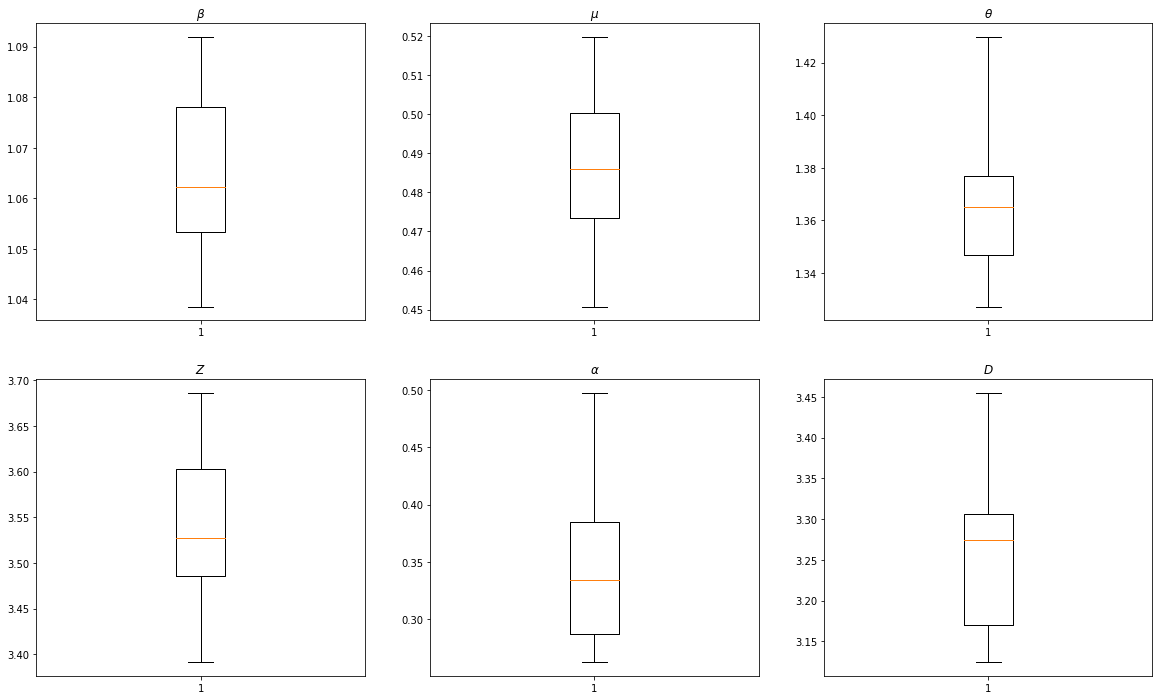

In [170]:
fig, axs = plt.subplots(2, 3, figsize=(20,12))
axs[0, 0].boxplot(np.array(best_parameters.documented_infectious_tx_rate),
                  whis=(2.5,97.5), sym='')
axs[0, 0].set_title(r'$\beta$')

axs[0, 1].boxplot(np.array(best_parameters.undocumented_infectious_tx_relative_rate),
                  whis=(2.5,97.5), sym='')
axs[0, 1].set_title(r'$\mu$')

axs[0, 2].boxplot(np.array(best_parameters.intercity_underreporting_factor),
                  whis=(2.5,97.5), sym='')
axs[0, 2].set_title(r'$\theta$')

axs[1, 0].boxplot(np.array(best_parameters.average_latency_period),
                  whis=(2.5,97.5), sym='')
axs[1, 0].set_title(r'$Z$')

axs[1, 1].boxplot(np.array(best_parameters.fraction_of_documented_infections),
                  whis=(2.5,97.5), sym='')
axs[1, 1].set_title(r'$\alpha$')

axs[1, 2].boxplot(np.array(best_parameters.average_infection_duration),
                  whis=(2.5,97.5), sym='')
axs[1, 2].set_title(r'$D$')
plt.show()

## Predictions time!

In [171]:
# create some np arrays for validation
# we will use data for last 15 days

val_observed_daily_infectious_count = raw_incidence.to_numpy()[30:, :]
val_observed_daily_infectious_count = np.transpose(
    val_observed_daily_infectious_count).astype(np.float32)

val_mobility_matrix_over_time = get_mobility_matrix(31, 46)

print('Mobility Matrix over time should have shape (75, 75, 15): {}'.format(
    val_mobility_matrix_over_time.shape))
print('Observed Infectious should have shape (75, 15): {}'.format(
    val_observed_daily_infectious_count.shape))
print('Initial population should have shape (75): {}'.format(
    initial_population.shape))

Mobility Matrix over time should have shape (75, 75, 15): (75, 75, 15)
Observed Infectious should have shape (75, 15): (75, 15)
Initial population should have shape (75): (75,)


In [172]:
# Taking mean of the states for now.
# The output state has shape (300, 30, 75)
# 300 -> number of ensembles
# 30  -> batch size
# 75  -> number of districts

state_susceptible = np.mean(eakf_state.particles.state.susceptible, axis=(0,1))
state_exposed = np.mean(eakf_state.particles.state.exposed, axis=(0,1))
state_daily_new_documented_infectious = np.mean(eakf_state.particles.state.daily_new_documented_infectious, axis=(0,1))
state_documented_infectious = np.mean(eakf_state.particles.state.documented_infectious, axis=(0,1))
state_undocumented_infectious = np.mean(eakf_state.particles.state.undocumented_infectious, axis=(0,1))

model_state = SEIRComponents(
    susceptible=state_susceptible,
    exposed=state_exposed,
    daily_new_documented_infectious=state_daily_new_documented_infectious,
    documented_infectious=state_documented_infectious,
    undocumented_infectious=state_undocumented_infectious
)

param_documented_infectious_tx_rate = np.mean(best_parameters.documented_infectious_tx_rate)
param_average_infection_duration = np.mean(best_parameters.average_infection_duration)
param_average_latency_period = np.mean(best_parameters.average_latency_period)
param_fraction_of_documented_infections = np.mean(best_parameters.fraction_of_documented_infections)
param_intercity_underreporting_factor = np.mean(best_parameters.intercity_underreporting_factor)
param_undocumented_infectious_tx_relative_rate = np.mean(best_parameters.undocumented_infectious_tx_relative_rate)

model_params = ModelParams(
    documented_infectious_tx_rate=param_documented_infectious_tx_rate,
    average_infection_duration=param_average_infection_duration,
    average_latency_period=param_average_latency_period,
    fraction_of_documented_infections=param_fraction_of_documented_infections,
    intercity_underreporting_factor=param_intercity_underreporting_factor,
    undocumented_infectious_tx_relative_rate= param_undocumented_infectious_tx_relative_rate
)

## Experiment 1
#### Directly calling `sample_state_deltas`

In [181]:
all_days = []
curr_state = model_state
daily_infectious_counts = []
daily_new_infectious_delta = []

for i in range(15):
    next_state_delta = sample_state_deltas(curr_state, initial_population, val_mobility_matrix_over_time[:,:,i], model_params, 0)
    next_state = SEIRComponents(
        susceptible=np.array(curr_state.susceptible) + np.array(next_state_delta.susceptible),
        exposed=np.array(curr_state.exposed) + np.array(next_state_delta.exposed),
        documented_infectious=np.array(curr_state.documented_infectious) + np.array(next_state_delta.documented_infectious),
        daily_new_documented_infectious=np.array(curr_state.daily_new_documented_infectious) + np.array(next_state_delta.daily_new_documented_infectious),
        undocumented_infectious=np.array(curr_state.undocumented_infectious) + np.array(next_state_delta.undocumented_infectious)
    )

    daily_infectious_counts.append(next_state_delta.documented_infectious)
    daily_new_infectious_delta.append(next_state_delta.daily_new_documented_infectious)
    
    all_days.append(next_state)
    curr_state = next_state

In [182]:
# figure out some district indices
print(raw_population.District[6])
print(raw_population.District[UDAYAPUR_IDX])
print(raw_population.District[34])
print(raw_population.District[51])
print(raw_population.District[32])
print(raw_population.District[59])

Banke
Udayapur
Kathmandu valley
Parsa
Kapilbastu
Rupandehi


Text(0.5, 0.98, 'Comparision between observed and predicted daily new cases')

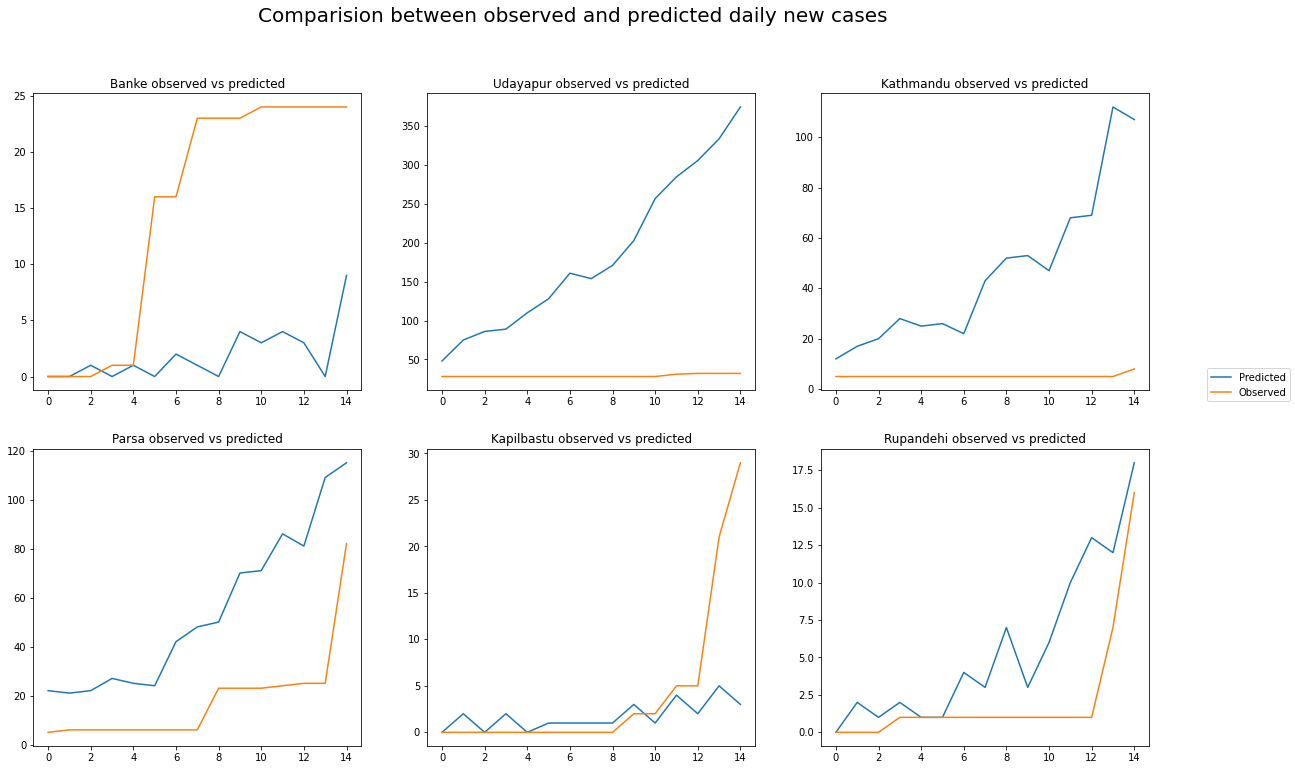

In [183]:
fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].plot(np.array(daily_new_infectious_delta)[:, 6], label='Predicted')
axs[0, 0].plot(val_observed_daily_infectious_count[6, :], label='Observed')
axs[0, 0].set_title('Banke observed vs predicted')

axs[0, 1].plot(np.array(daily_new_infectious_delta)[:, UDAYAPUR_IDX], label='Predicted')
axs[0, 1].plot(val_observed_daily_infectious_count[UDAYAPUR_IDX, :], label='Observed')
axs[0, 1].set_title('Udayapur observed vs predicted')

axs[0, 2].plot(np.array(daily_new_infectious_delta)[:, 34], label='Predicted')
axs[0, 2].plot(val_observed_daily_infectious_count[34, :], label='Observed')
axs[0, 2].set_title('Kathmandu observed vs predicted')

axs[1, 0].plot(np.array(daily_new_infectious_delta)[:, 51], label='Predicted')
axs[1, 0].plot(val_observed_daily_infectious_count[51, :], label='Observed')
axs[1, 0].set_title('Parsa observed vs predicted')

axs[1, 1].plot(np.array(daily_new_infectious_delta)[:, 32], label='Predicted')
axs[1, 1].plot(val_observed_daily_infectious_count[32, :], label='Observed')
axs[1, 1].set_title('Kapilbastu observed vs predicted')

axs[1, 2].plot(np.array(daily_new_infectious_delta)[:, 59], label='Predicted')
axs[1, 2].plot(val_observed_daily_infectious_count[59, :], label='Observed')
axs[1, 2].set_title('Rupandehi observed vs predicted')

lines = []
labels = []

for ax in fig.axes[:1]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

fig.legend(lines, labels, loc = 'center right')
fig.suptitle('Comparision between observed and predicted daily new cases', fontsize=20)

#### Looks resonable  
District Salyan does not have any documented infectious individuals. Let's see what our model says about that.

Text(0.5, 1.0, 'Salyan observed vs predicted')

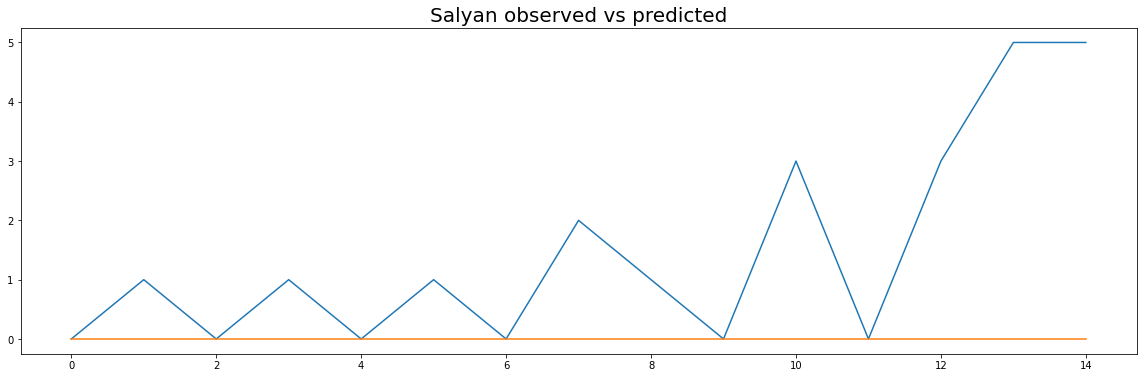

In [184]:
plt.figure(figsize=(20,6))
plt.plot(np.array(daily_new_infectious_delta)[:, 60], label='Predicted')
plt.plot(val_observed_daily_infectious_count[60, :], label='Observed')
plt.title('Salyan observed vs predicted', fontsize=20)

Not bad.

## Experiment 2
#### Do not just take mean of the ensembles. Plot their standard deviations as well

In [204]:
state_susceptible_with_std = np.mean(eakf_state.particles.state.susceptible, axis=1)
state_exposed_with_std = np.mean(eakf_state.particles.state.exposed, axis=1)
state_daily_new_documented_infectious_with_std = np.mean(eakf_state.particles.state.daily_new_documented_infectious, axis=1)
state_documented_infectious_with_std = np.mean(eakf_state.particles.state.documented_infectious, axis=1)
state_undocumented_infectious_with_std = np.mean(eakf_state.particles.state.undocumented_infectious, axis=1)

model_state_with_std = SEIRComponents(
    susceptible=state_susceptible_with_std,
    exposed=state_exposed_with_std,
    daily_new_documented_infectious=state_daily_new_documented_infectious_with_std,
    documented_infectious=state_documented_infectious_with_std,
    undocumented_infectious=state_undocumented_infectious_with_std
)

In [205]:
model_state_with_std.susceptible.shape

(300, 75)

In [312]:
t_all_days = []
t_curr_state = model_state_with_std
t_daily_infectious_counts = []
t_daily_new_infectious_delta = []
t_undocumented_infectious = []

for i in range(15):
    t_next_state_delta = sample_state_deltas(t_curr_state, initial_population, val_mobility_matrix_over_time[:,:,i], model_params, 0)
    t_next_state = SEIRComponents(
        susceptible=np.array(t_curr_state.susceptible) + np.array(t_next_state_delta.susceptible),
        exposed=np.array(t_curr_state.exposed) + np.array(t_next_state_delta.exposed),
        documented_infectious=np.array(t_curr_state.documented_infectious) + np.array(t_next_state_delta.documented_infectious),
        daily_new_documented_infectious=np.array(t_curr_state.daily_new_documented_infectious) + np.array(t_next_state_delta.daily_new_documented_infectious),
        undocumented_infectious=np.array(t_curr_state.undocumented_infectious) + np.array(t_next_state_delta.undocumented_infectious)
    )

    t_daily_infectious_counts.append(t_next_state_delta.documented_infectious)
    t_daily_new_infectious_delta.append(t_next_state_delta.daily_new_documented_infectious)
    t_undocumented_infectious.append(t_next_state_delta.undocumented_infectious)
    
    t_all_days.append(t_next_state)
    t_curr_state = t_next_state

In [313]:
t_daily_new_infectious_delta = np.array(t_daily_new_infectious_delta)
t_undocumented_infectious = np.array(t_undocumented_infectious)

In [314]:
t_daily_new_infectious_delta.shape

(15, 300, 75)

In [317]:
d_mean = np.mean(t_daily_new_infectious_delta, axis=1).round()
d_std = np.std(t_daily_new_infectious_delta, axis=1).round()
d_upper = d_mean + d_std
d_lower = d_mean - d_std

# make sure lower bounds do not go below 0
d_lower = np.vectorize(lambda x: x if x >=0 else 0)(d_lower)
d_mean.shape

(15, 75)

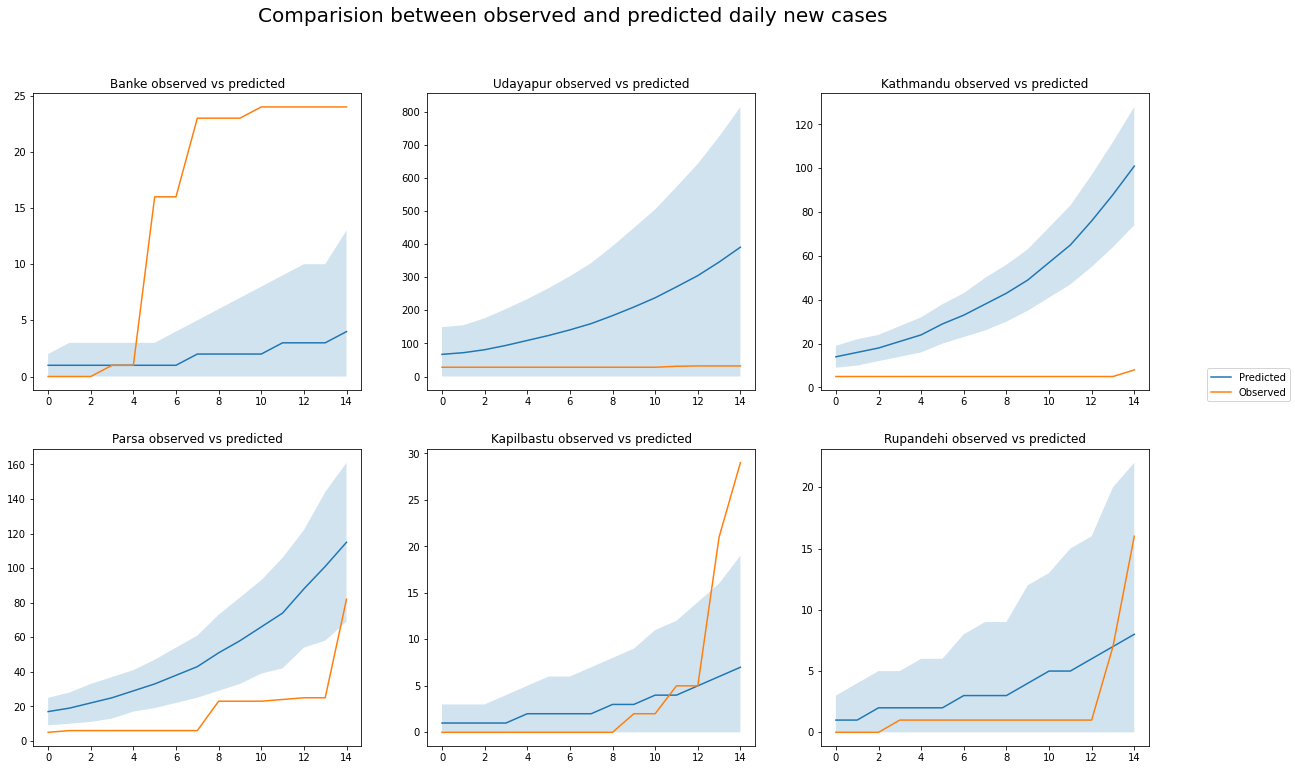

In [337]:
fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].plot(d_mean[:, 6], label='Predicted')
axs[0, 0].plot(val_observed_daily_infectious_count[6, :], label='Observed')
axs[0, 0].fill_between(np.arange(0,15,1), d_upper[:, 6], d_lower[:, 6], alpha=0.2)
axs[0, 0].set_title('Banke observed vs predicted')

axs[0, 1].plot(d_mean[:, UDAYAPUR_IDX], label='Predicted')
axs[0, 1].plot(val_observed_daily_infectious_count[UDAYAPUR_IDX, :], label='Observed')
axs[0, 1].fill_between(np.arange(0,15,1), d_upper[:, UDAYAPUR_IDX], d_lower[:, UDAYAPUR_IDX], alpha=0.2)
axs[0, 1].set_title('Udayapur observed vs predicted')

axs[0, 2].plot(d_mean[:, 34], label='Predicted')
axs[0, 2].plot(val_observed_daily_infectious_count[34, :], label='Observed')
axs[0, 2].fill_between(np.arange(0,15,1), d_upper[:, 34], d_lower[:, 34], alpha=0.2)
axs[0, 2].set_title('Kathmandu observed vs predicted')

axs[1, 0].plot(d_mean[:, 51], label='Predicted')
axs[1, 0].plot(val_observed_daily_infectious_count[51, :], label='Observed')
axs[1, 0].fill_between(np.arange(0,15,1), d_upper[:, 51], d_lower[:, 51], alpha=0.2)
axs[1, 0].set_title('Parsa observed vs predicted')

axs[1, 1].plot(d_mean[:, 32], label='Predicted')
axs[1, 1].plot(val_observed_daily_infectious_count[32, :], label='Observed')
axs[1, 1].fill_between(np.arange(0,15,1), d_upper[:, 32], d_lower[:, 32], alpha=0.2)
axs[1, 1].set_title('Kapilbastu observed vs predicted')

axs[1, 2].plot(d_mean[:, 59], label='Predicted')
axs[1, 2].plot(val_observed_daily_infectious_count[59, :], label='Observed')
axs[1, 2].fill_between(np.arange(0,15,1), d_upper[:, 59], d_lower[:, 59], alpha=0.2)
axs[1, 2].set_title('Rupandehi observed vs predicted')

lines = []
labels = []

for ax in fig.axes[:1]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

fig.legend(lines, labels, loc = 'center right')
fig.suptitle('Comparision between observed and predicted daily new cases', fontsize=20)

fig.savefig('../saved_plots/obs-vs-pred-new-cases.jpg')

## Experiment 3
#### Plot documented and undocumented infectious numbers

In [320]:
ud_infectious_mean = np.mean(t_undocumented_infectious, axis=1)
ud_infectious_mean.shape

(15, 75)

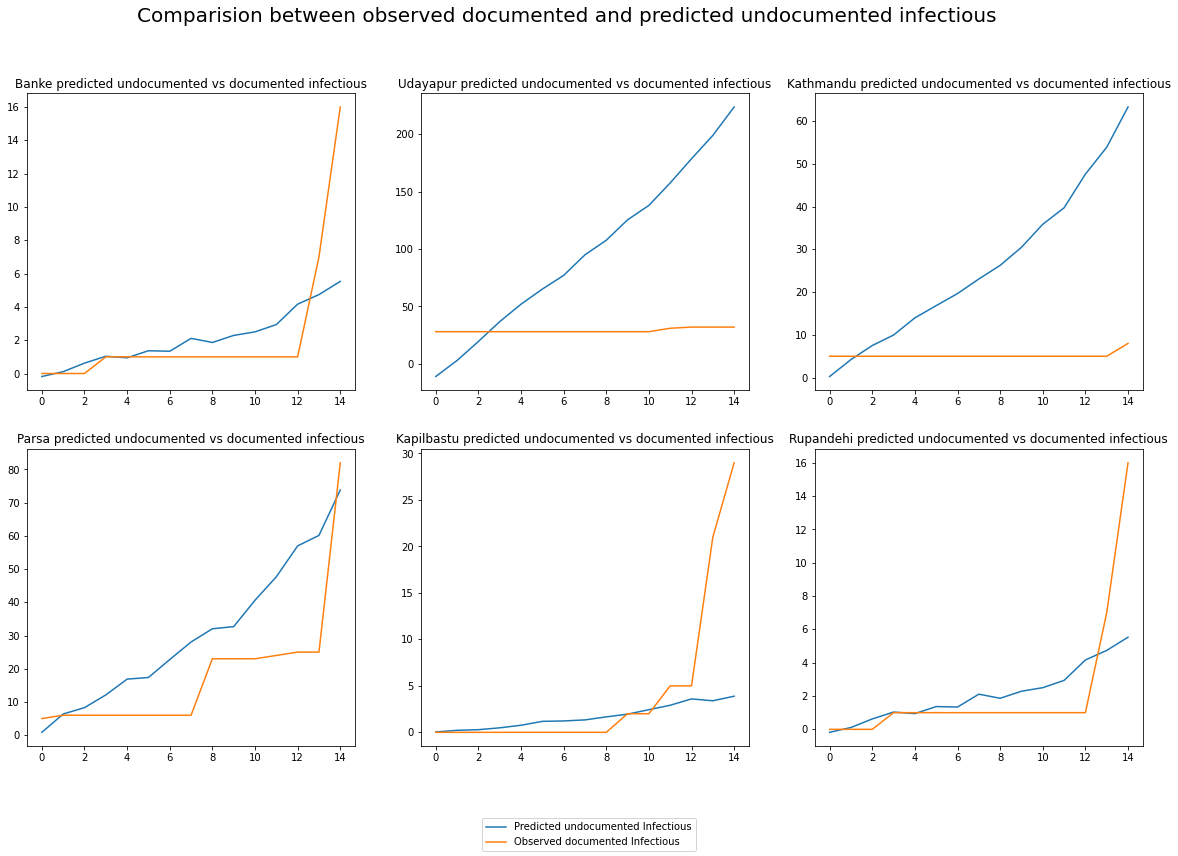

In [338]:
fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].plot(ud_infectious_mean[:,59], label='Predicted undocumented Infectious')
axs[0, 0].plot(val_observed_daily_infectious_count[59, :], label='Observed documented Infectious')
axs[0, 0].set_title('Banke predicted undocumented vs documented infectious')

axs[0, 1].plot(ud_infectious_mean[:,UDAYAPUR_IDX], label='Predicted undocumented Infectious')
axs[0, 1].plot(val_observed_daily_infectious_count[UDAYAPUR_IDX, :], label='Observed documented Infectious')
axs[0, 1].set_title('Udayapur predicted undocumented vs documented infectious')

axs[0, 2].plot(ud_infectious_mean[:,34], label='Predicted undocumented Infectious')
axs[0, 2].plot(val_observed_daily_infectious_count[34, :], label='Observed documented Infectious')
axs[0, 2].set_title('Kathmandu predicted undocumented vs documented infectious')

axs[1, 0].plot(ud_infectious_mean[:,51], label='Predicted undocumented Infectious')
axs[1, 0].plot(val_observed_daily_infectious_count[51, :], label='Observed documented Infectious')
axs[1, 0].set_title('Parsa predicted undocumented vs documented infectious')

axs[1, 1].plot(ud_infectious_mean[:,32], label='Predicted undocumented Infectious')
axs[1, 1].plot(val_observed_daily_infectious_count[32, :], label='Observed documented Infectious')
axs[1, 1].set_title('Kapilbastu predicted undocumented vs documented infectious')

axs[1, 2].plot(ud_infectious_mean[:,59], label='Predicted undocumented Infectious')
axs[1, 2].plot(val_observed_daily_infectious_count[59, :], label='Observed documented Infectious')
axs[1, 2].set_title('Rupandehi predicted undocumented vs documented infectious')

lines = []
labels = []

for ax in fig.axes[:1]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

fig.legend(lines, labels, loc = 'lower center')
fig.suptitle('Comparision between observed documented and predicted undocumented infectious', fontsize=20)

fig.savefig('../saved_plots/obs-documented-vs-pred-undocumented-cases.jpg')